In [21]:
import pandas as pd

file_path = 'FinancialMarketData.csv'
df = pd.read_csv(file_path)#reading file data
print(df.head(), df.shape)


   Y       Data  XAU BGNL  ECSURPUS    BDIY     CRY     DXY     JPY    GBP  \
0  0  1/11/2000    283.25     0.077  1388.0  157.26  100.56  105.86  1.646   
1  0  1/18/2000    287.65     0.043  1405.0  165.01  101.86  105.47  1.638   
2  0  1/25/2000    287.15     0.135  1368.0  167.24  102.41  106.04  1.650   
3  0   2/1/2000    282.75     0.191  1311.0  166.85  104.92  107.85  1.611   
4  1   2/8/2000    298.40     0.312  1277.0  165.43  104.22  109.30  1.611   

     Cl1  ...  LP01TREU  EMUSTRUU  LF94TRUU     MXUS    MXEU     MXJP    MXBR  \
0  25.77  ...   116.464   230.527   123.762  1416.12  127.75   990.59  856.76   
1  28.85  ...   117.267   231.377   123.762  1428.79  129.50   993.98  925.22   
2  28.28  ...   117.995   232.390   123.762  1385.93  126.48   974.83  886.93   
3  28.22  ...   120.510   231.942   122.328  1385.31  129.19  1007.12  842.60   
4  28.02  ...   118.791   237.812   122.328  1411.95  134.67  1034.58  945.15   

     MXRU    MXIN   MXCN  
0  224.33  217.34

Supervised data training for part I

# What each column does accordingly:
# 	1.	Y, Data: Likely represent the dependent variable (Y) and the date (Data) for time-series data.
# 	2.	XAU: Represents gold prices (commonly used symbol for gold in finance).
# 	3.	BGNL: Could stand for Bloomberg Generic Index, or a custom abbreviation.
# 	4.	ECSURPUS: Economic surplus (specific to the U.S. or another economy).
# 	5.	BDIY: Baltic Dry Index, a measure of shipping and trade activity.
# 	6.	CRY: CRB Commodity Index, tracking commodity prices.
# 	7.	DXY: U.S. Dollar Index, a measure of the dollar’s strength against other currencies.
# 	8.	JPY, GBP: Exchange rates for Japanese Yen and British Pound, respectively.
# 	9.	Cl1: WTI Crude Oil Futures (CL is the ticker for crude oil futures).
# 	10.	VIX: Volatility Index, measuring market volatility.
# 	11.	USGG30YR, GT10, USGG2YR, USGG3M, US0001M: U.S. Treasury yields for 30-year, 10-year, 2-year, 3-month, and 1-month bonds.
# 	12.	GTDEM30Y, GTDEM10Y, GTDEM2Y: German government bond yields (30-year, 10-year, 2-year).
# 	13.	EONIA: Euro Overnight Index Average, a benchmark for euro interbank lending.
# 	14.	GTITL30YR, GTITL10YR, GTITL2YR: Italian government bond yields (30-year, 10-year, 2-year).
# 	15.	GTJPY30YR, GTJPY10YR, GTJPY2YR: Japanese government bond yields (30-year, 10-year, 2-year).
# 	16.	GTGBP30Y, GTGBP20Y, GTGBP2Y: British government bond yields (30-year, 20-year, 2-year).
# 	17.	LUMSTRUU: Likely a Bloomberg index, e.g., Bloomberg US Mortgage Backed Securities Index.
# 	18.	LMBITR: Bloomberg Municipal Bond Index Total Return.
# 	19.	LUACTRUU: Bloomberg U.S. Corporate Aggregate Total Return Index.
# 	20.	LF98TRUU: Bloomberg Global High Yield Index.
# 	21.	LG30TRUU: Bloomberg Global Aggregate 30-Year Total Return Index.
# 	22.	LP01TREU: Likely Bloomberg Pan-European Corporate Total Return Index.
# 	23.	EMUSTRUU: Bloomberg Eurozone Aggregate Total Return Index.
# 	24.	LF94TRUU: Bloomberg Global Emerging Market Corporate Total Return Index.
# 	25.	MXUS, MXEU, MXJP, MXBR, MXRU, MXIN, MXCN: MSCI indices for countries/regions (U.S., Europe, Japan, Brazil, Russia, India, China).


In [34]:
!pip3 install scikit-learn
!pip3 install xgboost
!pip3 install matplotlib
!pip3 install seaborn

/var/folders/j7/3d4frtsd6kscrrzr06pgnyrr0000gn/T/ipykernel_77965/439284019.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       175
           1       0.76      0.85      0.80        48

    accuracy                           0.91       223
   macro avg       0.86      0.89      0.87       223
weighted avg       0.92      0.91      0.91       223



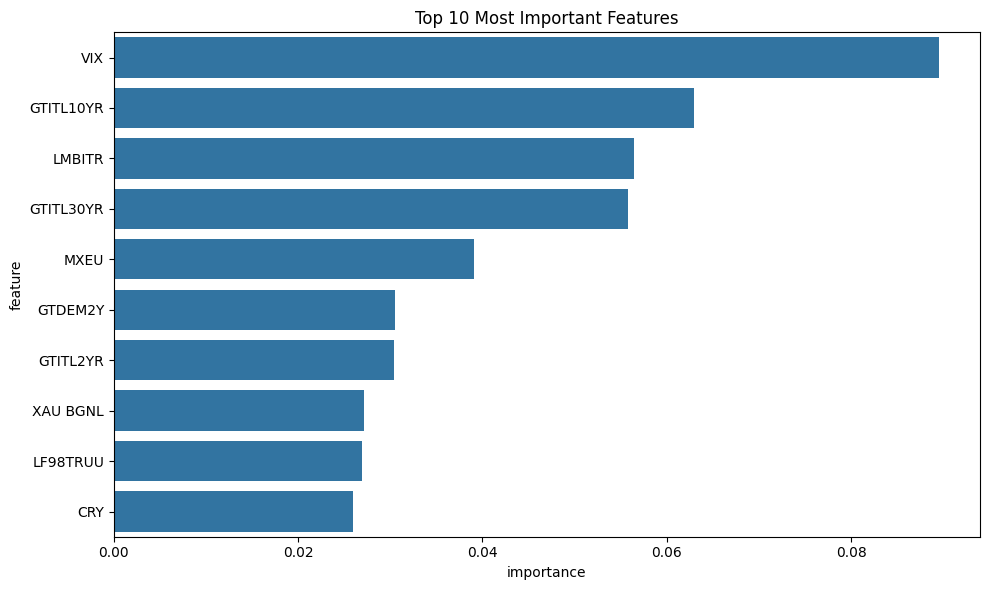

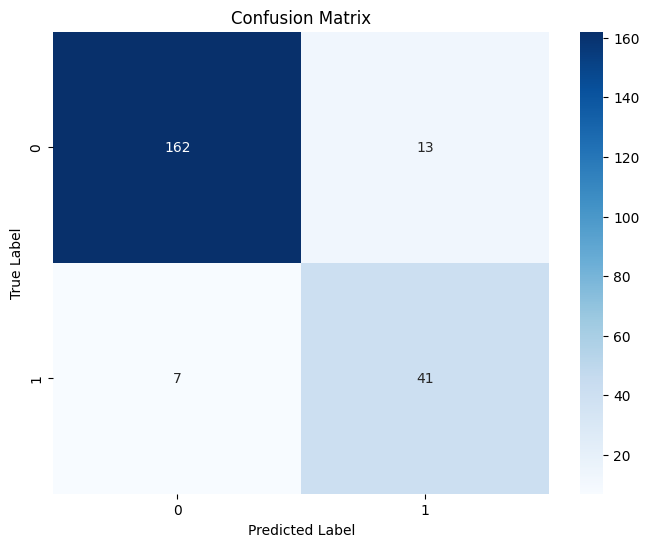

In [36]:
# XGB classifier version 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data(df):
    X = df.drop(['Y', 'Data'], axis=1) # drop dat columns, non-feature columns
    y = df['Y']
    X = X.fillna(method='ffill').fillna(method='bfill')
    
    scaler = StandardScaler() # feature scaling
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled, y

def train_model(X, y):
    n_samples = len(y)
    n_classes = len(np.unique(y)) # find class weights and train XGBoost model
    class_weights = dict(zip(
        np.unique(y),
        n_samples / (n_classes * np.bincount(y))
    ))
    
    model = XGBClassifier(
        scale_pos_weight = class_weights[1]/class_weights[0], # class imbalance
        max_depth = 4, # tree depth
        learning_rate = 0.05,
        n_estimators = 200, # number of trees
        min_child_weight = 6, # min weight sum 
        subsample = 0.8, # data usage for tree
        colsample_bytree = 0.8, # data feature for tree
        random_state = 42 # reproducibility
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    model.fit(X_train, y_train)    
    return model, X_train, X_test, y_train, y_test

def evaluate_model(model, X_test, y_test, feature_names): # model evals
    y_pred = model.predict(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    importance_df = importance_df.sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def main():
    df = pd.read_csv('FinancialMarketData.csv')    
    X, y = prepare_data(df)
    
    model, X_train, X_test, y_train, y_test = train_model(X, y)    
    evaluate_model(model, X_test, y_test, X.columns)
    
    return model

if __name__ == "__main__":
    model = main()

More accurate model

/var/folders/j7/3d4frtsd6kscrrzr06pgnyrr0000gn/T/ipykernel_77965/2502691094.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')



Cross-validation Results:
Average F1-Score for no-crash (0): 0.941
Average F1-Score for crash (1): 0.784

Optimal threshold: 0.488

Classification Report (with optimized threshold):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       175
           1       0.81      0.88      0.84        48

    accuracy                           0.93       223
   macro avg       0.89      0.91      0.90       223
weighted avg       0.93      0.93      0.93       223



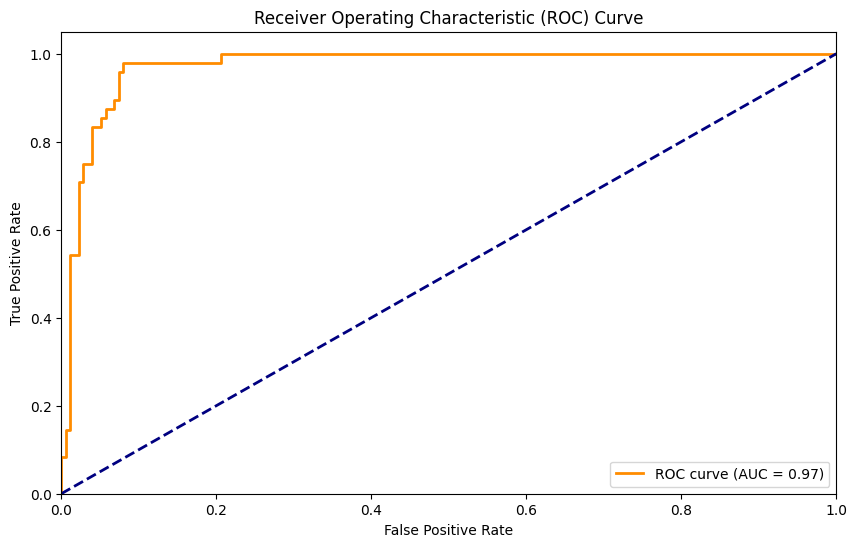

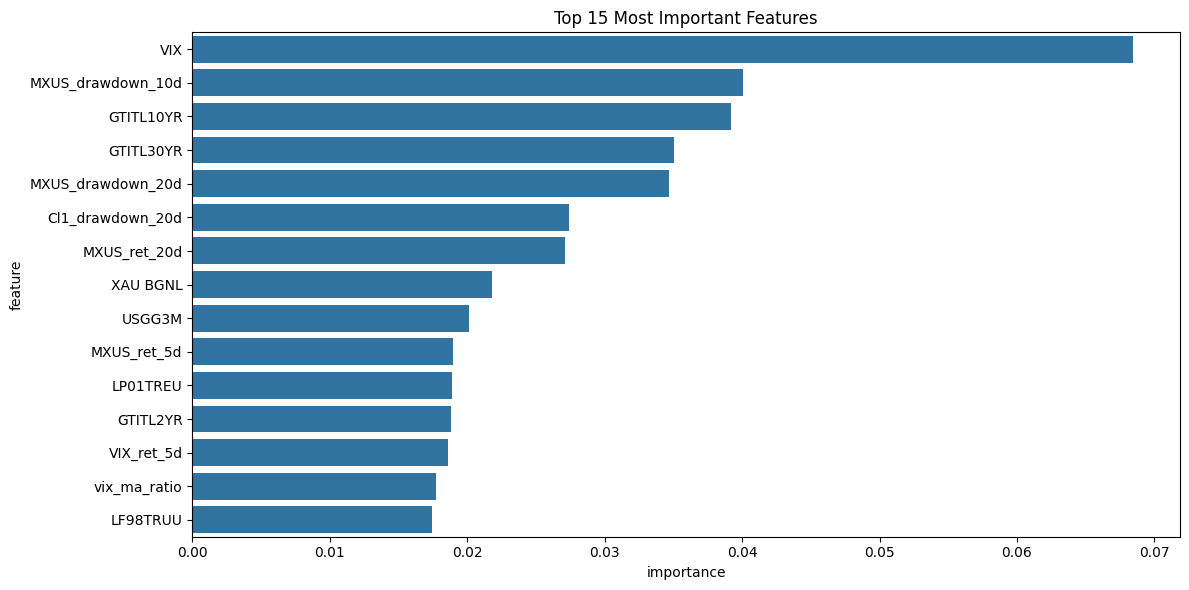

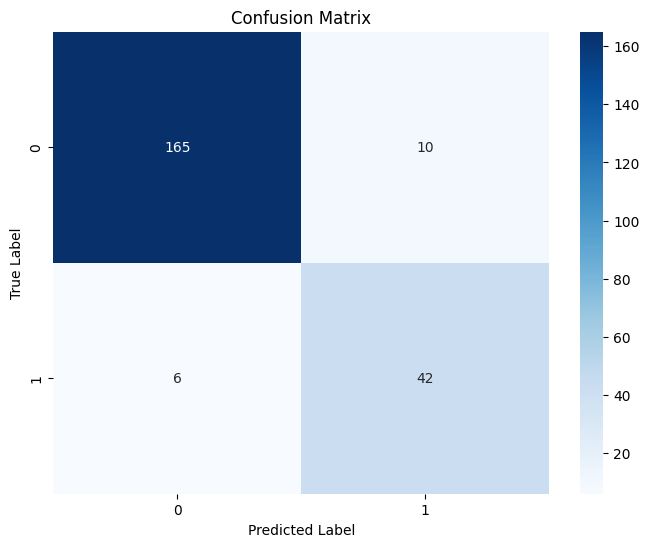

In [37]:
# Version II

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def engineer_features(df):
    df_eng = df.copy()
    volatility_windows = [5, 10, 20] # rolling volatility
    key_columns = ['VIX', 'MXUS', 'DXY', 'Cl1']
    
    for col in key_columns:
        for window in volatility_windows:
            df_eng[f'{col}_vol_{window}d'] = df_eng[col].rolling(window).std()
            df_eng[f'{col}_ret_{window}d'] = df_eng[col].pct_change(window)
            rolling_max = df_eng[col].rolling(window).max()
            daily_drawdown = df_eng[col]/rolling_max - 1
            df_eng[f'{col}_drawdown_{window}d'] = daily_drawdown.rolling(window).min()
    
    df_eng['yield_spread_10_2'] = df_eng['GT10'] - df_eng['USGG2YR'] # yield curve spreads
    df_eng['yield_spread_30_10'] = df_eng['USGG30YR'] - df_eng['GT10']
    
    df_eng['vix_ma_ratio'] = df_eng['VIX'] / df_eng['VIX'].rolling(20).mean() # Market stress indicators
    df_eng['gold_dxy_ratio'] = df_eng['XAU BGNL'] / df_eng['DXY']
    
    return df_eng

def find_optimal_threshold(y_true, y_pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    optimal_threshold = thresholds[np.argmax(f1_scores[:-1])]  # Last element is for threshold=1.0
    return optimal_threshold

def prepare_data(df):
    df_engineered = engineer_features(df)
    
    X = df_engineered.drop(['Y', 'Data'], axis=1)
    y = df_engineered['Y']
    
    X = X.fillna(method='ffill').fillna(method='bfill')
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled, y

def train_model_with_cv(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    optimal_thresholds = []
    models = []
    fold_scores = []
    
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    n_samples = len(y_train_full)
    n_classes = len(np.unique(y_train_full))
    class_weights = dict(zip(
        np.unique(y_train_full),
        n_samples / (n_classes * np.bincount(y_train_full))
    ))
    
    model = XGBClassifier(
        scale_pos_weight=class_weights[1]/class_weights[0],
        max_depth=4,
        learning_rate=0.05,
        n_estimators=300,  
        min_child_weight=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
        
        model.fit(X_train, y_train)
        
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        opt_threshold = find_optimal_threshold(y_val, y_pred_proba)
        optimal_thresholds.append(opt_threshold)
        y_pred = (y_pred_proba >= opt_threshold).astype(int)
        fold_score = classification_report(y_val, y_pred, output_dict=True)
        fold_scores.append(fold_score)
        
        models.append(model)
    
    final_threshold = np.mean(optimal_thresholds)
    
    final_model = XGBClassifier(
        scale_pos_weight=class_weights[1]/class_weights[0],
        max_depth=4,
        learning_rate=0.05,
        n_estimators=300,
        min_child_weight=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    final_model.fit(X_train_full, y_train_full)
    return final_model, final_threshold, X_test, y_test, fold_scores

def evaluate_model(model, X_test, y_test, threshold, feature_names):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    print("\nClassification Report (with optimized threshold):")
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})') # evals how well any binary classification model performs across all possible classification thresholds
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot feature importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    importance_df = importance_df.sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Top 15 Most Important Features')
    plt.tight_layout()
    plt.show()
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return importance_df

def main():
    df = pd.read_csv('FinancialMarketData.csv')
    X, y = prepare_data(df)
    
    model, optimal_threshold, X_test, y_test, fold_scores = train_model_with_cv(X, y)
    print("\nCross-validation Results:")
    avg_scores = {
        metric: np.mean([fold[metric]['f1-score'] for fold in fold_scores])
        for metric in ['0', '1']
    }
    print(f"Average F1-Score for no-crash (0): {avg_scores['0']:.3f}")
    print(f"Average F1-Score for crash (1): {avg_scores['1']:.3f}")
    print(f"\nOptimal threshold: {optimal_threshold:.3f}")
    
    importance_df = evaluate_model(model, X_test, y_test, optimal_threshold, X.columns)
    
    return model, optimal_threshold, importance_df

if __name__ == "__main__":
    model, threshold, importance = main()

Part II: Max Returns and Min Losses investment strategy AI agent


Strategy Performance Metrics:
total_return: inf
annual_return: 391697.28
volatility: 9731.54
sharpe_ratio: 40.25
max_drawdown: 0.00
win_rate: 100.00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/matplotlib/ticker.py:2176: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


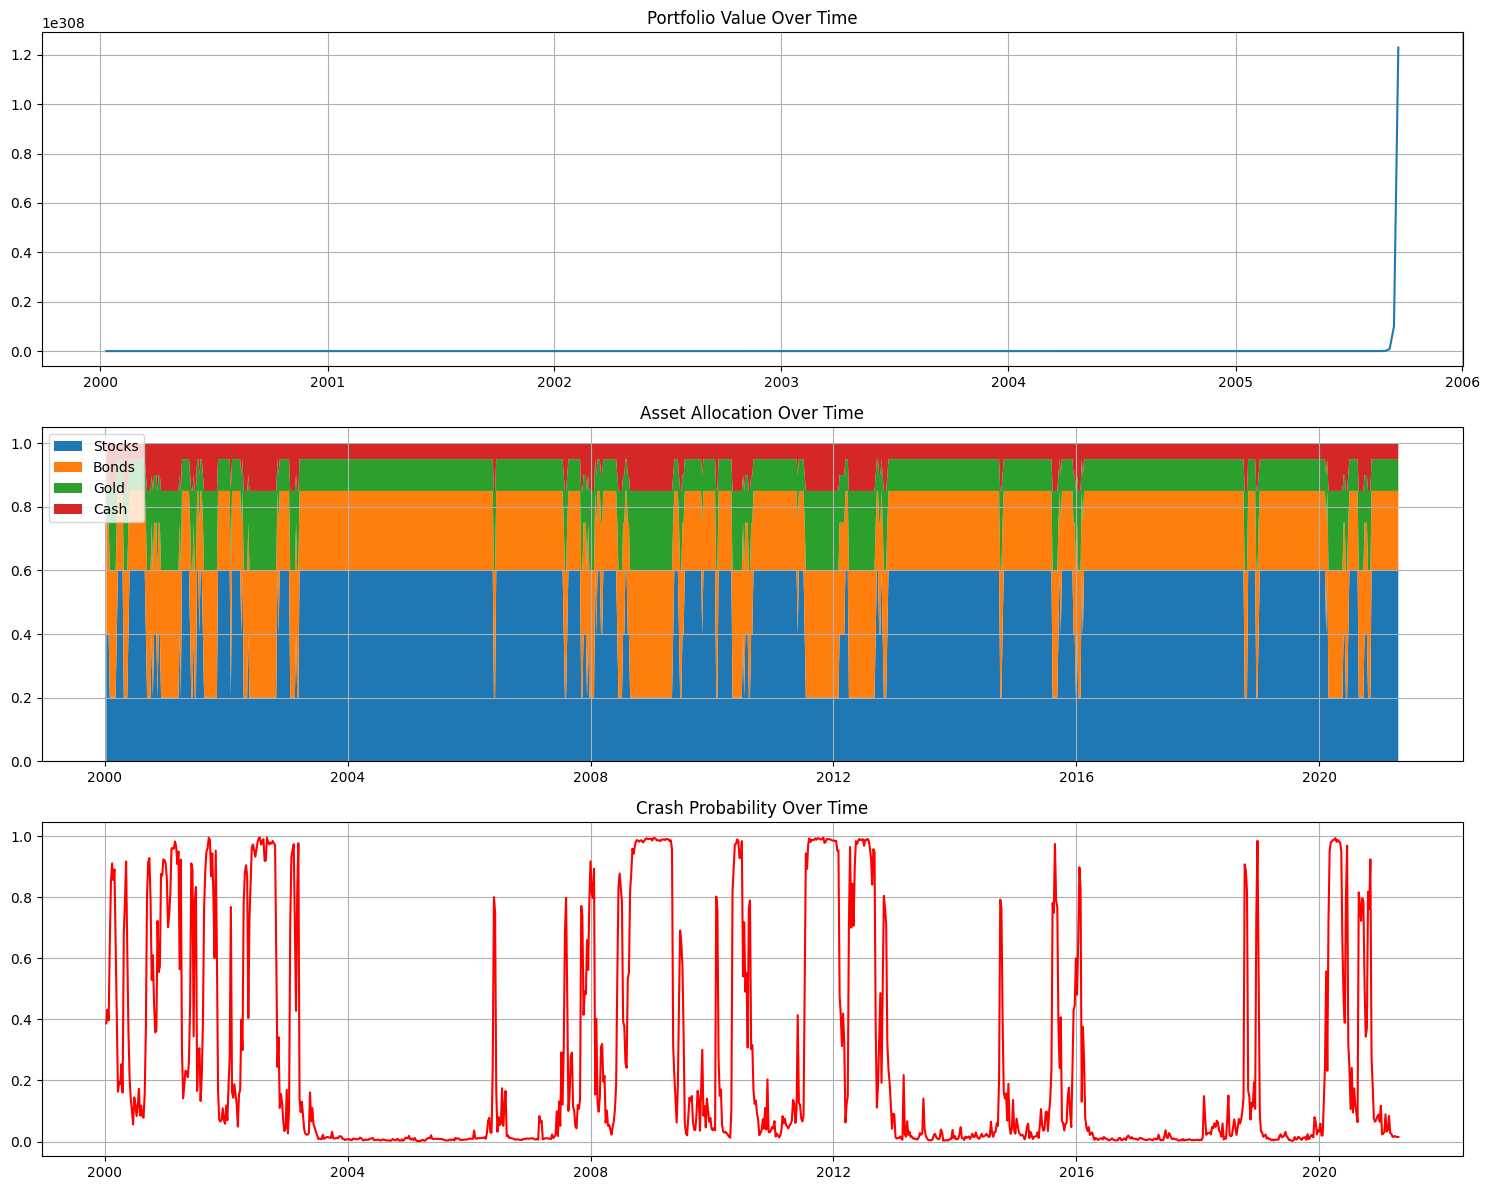

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

class MarketCrashPredictor:
    def __init__(self):
        self.model = None
        self.optimal_threshold = None
        self.scaler = StandardScaler()
        
    def find_optimal_threshold(self, y_true, y_pred_proba):
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        optimal_threshold = thresholds[np.argmax(f1_scores[:-1])]
        return optimal_threshold
    
    def train(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        self.model = XGBClassifier(
            scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
            max_depth=4,
            learning_rate=0.05,
            n_estimators=200,
            min_child_weight=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        
        self.model.fit(X_train_scaled, y_train)
        
        y_pred_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        self.optimal_threshold = self.find_optimal_threshold(y_test, y_pred_proba)
        
        return self.model, self.optimal_threshold

class DynamicPortfolioStrategy:
    def __init__(self, initial_capital: float = 1000000):
        self.initial_capital = initial_capital
        self.crash_predictor = MarketCrashPredictor()
        
    def calculate_portfolio_weights(self, crash_probability: float) -> dict:
        if crash_probability < 0.3:
            return {
                'stocks': 0.60,
                'bonds': 0.25,
                'gold': 0.10,
                'cash': 0.05
            }
        elif crash_probability < 0.6:
            return {
                'stocks': 0.40,
                'bonds': 0.35,
                'gold': 0.15,
                'cash': 0.10
            }
        else:
            return {
                'stocks': 0.20,
                'bonds': 0.40,
                'gold': 0.25,
                'cash': 0.15
            }

    def calculate_returns(self, row: pd.Series, weights: dict) -> tuple:
        returns = {
            'stocks': row['MXUS'] / 100,
            'bonds': row['LUACTRUU'] / 100,
            'gold': row['XAU BGNL'] / 100,
            'cash': row['US0001M'] / 252
        }
        
        portfolio_return = sum(weights[asset] * returns[asset] for asset in weights)
        return portfolio_return, returns

    def prepare_features(self, df: pd.DataFrame) -> pd.DataFrame:
        feature_cols = [col for col in df.columns if col not in ['Y', 'Data']]
        return df[feature_cols]

    def backtest_strategy(self, df: pd.DataFrame) -> pd.DataFrame:
        X = self.prepare_features(df)
        y = df['Y']
        
        self.crash_predictor.train(X, y)
        X_scaled = self.crash_predictor.scaler.transform(X)
        
        results = []
        portfolio_value = self.initial_capital
        
        for idx, row in df.iterrows():
            features = X_scaled[idx].reshape(1, -1)
            crash_prob = self.crash_predictor.model.predict_proba(features)[0][1]
            
            weights = self.calculate_portfolio_weights(crash_prob)
            
            daily_return, asset_returns = self.calculate_returns(row, weights)
            portfolio_value *= (1 + daily_return)
            
            results.append({
                'date': row['Data'],
                'portfolio_value': portfolio_value,
                'crash_probability': crash_prob,
                'daily_return': daily_return,
                'stock_weight': weights['stocks'],
                'bond_weight': weights['bonds'],
                'gold_weight': weights['gold'],
                'cash_weight': weights['cash']
            })
        
        return pd.DataFrame(results)

    def calculate_metrics(self, results_df: pd.DataFrame) -> dict:
        returns = results_df['daily_return']
        
        metrics = {
            'total_return': (results_df['portfolio_value'].iloc[-1] / self.initial_capital - 1) * 100,
            'annual_return': (returns.mean() * 252) * 100,
            'volatility': (returns.std() * np.sqrt(252)) * 100,
            'sharpe_ratio': (returns.mean() * 252) / (returns.std() * np.sqrt(252)),
            'max_drawdown': self.calculate_max_drawdown(results_df['portfolio_value']) * 100,
            'win_rate': (returns > 0).mean() * 100
        }
        
        return metrics

    @staticmethod
    def calculate_max_drawdown(portfolio_values: pd.Series) -> float:
        rolling_max = portfolio_values.expanding().max()
        drawdowns = portfolio_values / rolling_max - 1
        return drawdowns.min()

    def plot_results(self, results_df: pd.DataFrame):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
        
        ax1.plot(pd.to_datetime(results_df['date']), results_df['portfolio_value'])
        ax1.set_title('Portfolio Value Over Time')
        ax1.grid(True)
        
        ax2.stackplot(pd.to_datetime(results_df['date']),
                     [results_df['stock_weight'], results_df['bond_weight'],
                      results_df['gold_weight'], results_df['cash_weight']],
                     labels=['Stocks', 'Bonds', 'Gold', 'Cash'])
        ax2.set_title('Asset Allocation Over Time')
        ax2.legend(loc='upper left')
        ax2.grid(True)
        
        ax3.plot(pd.to_datetime(results_df['date']), results_df['crash_probability'], color='red')
        ax3.set_title('Crash Probability Over Time')
        ax3.grid(True)
        
        plt.tight_layout()
        plt.show()

def run_full_strategy(file_path: str):
    df = pd.read_csv(file_path)
    strategy = DynamicPortfolioStrategy()
    
    results_df = strategy.backtest_strategy(df)
    metrics = strategy.calculate_metrics(results_df)

    print("\nStrategy Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    
    strategy.plot_results(results_df)
    
    return results_df, metrics

if __name__ == "__main__":
    results_df, metrics = run_full_strategy('FinancialMarketData.csv')